In [1]:
import pandas as pd


df = pd.read_csv('data/ratings.csv')
ratings_matrix = df.pivot(index='userId', columns='movieId', values='rating')
print(ratings_matrix.head())

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     NaN     4.0     NaN     NaN     4.0     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     N

In [4]:
from scipy.sparse.linalg import svds
import numpy as np

ratings_matrix_filled = ratings_matrix.fillna(2.5)
R = ratings_matrix_filled.values
user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

u, sigma, v_t = svds(R_demeaned, k=3)
print(u)

[[-0.04690896  0.06013561 -0.072033  ]
 [ 0.00782418 -0.01932058 -0.0070822 ]
 [ 0.00152925 -0.00498683  0.00314296]
 ...
 [ 0.01757789 -0.03988334 -0.09409418]
 [-0.02443776  0.00334815 -0.00647216]
 [ 0.16238465 -0.15359705 -0.14808105]]


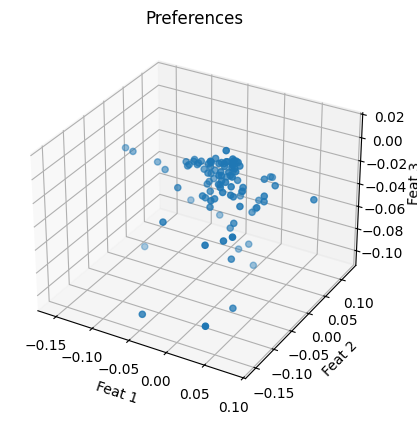

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

u_subset = u[:100, :]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(u_subset[:, 0], u_subset[:, 1], u_subset[:, 2], marker='o')

ax.set_title('Users Taste/Preferences')
ax.set_xlabel('Feat 1')
ax.set_ylabel('Feat 2')
ax.set_zlabel('Feat 3')

plt.show()

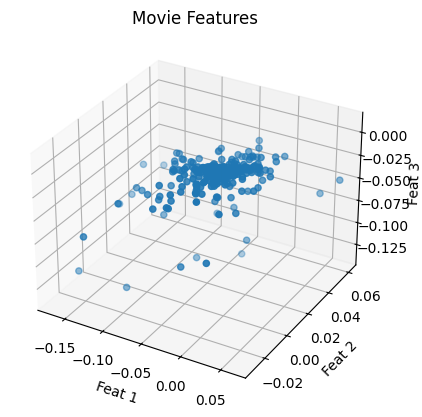

In [13]:
vt_subset = v_t.T[:500, :]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(vt_subset[:, 0], vt_subset[:, 1], vt_subset[:, 2], marker='o')

ax.set_title('Movie Features')
ax.set_xlabel('Feat 1')
ax.set_ylabel('Feat 2')
ax.set_zlabel('Feat 3')

plt.show()